In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
!pip install torch

In [3]:
# Load Data
Merged_data = pd.read_excel('Merged_data.xlsx')

Merged_data.set_index('Date', inplace=True)

Merged_data.interpolate(method='linear', inplace=True)  



In [5]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Merged_data_scaled = pd.DataFrame(scaler.fit_transform(Merged_data), columns=Merged_data.columns, index=Merged_data.index)

In [6]:
Merged_data_scaled.head()

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),et0_fao_evapotranspiration (mm),wind_speed_10m (km/h),wind_gusts_10m (km/h),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),Turbidity
Date,,,,,,,,,,
2020-12-31 15:00:00,0.284165,0.7250,0.0,0.063291,0.187023,0.184783,0.238342,0.828221,0.069797,0.011305
2020-12-31 16:00:00,0.271150,0.8125,0.0,0.025316,0.106870,0.164032,0.230570,0.828221,0.031726,0.013732
2020-12-31 17:00:00,0.229935,0.9250,0.0,0.012658,0.139313,0.078063,0.215026,0.825153,0.003807,0.013449
2020-12-31 18:00:00,0.214751,0.9375,0.0,0.000000,0.135496,0.075099,0.199482,0.822086,0.000000,0.011833
2020-12-31 19:00:00,0.195228,0.9625,0.0,0.000000,0.160305,0.084980,0.183938,0.819018,0.000000,0.010650


In [7]:
# Define sequence length
SEQ_LEN = 24  # Using past 24 time steps to predict the future

# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len].values
        y = self.data.iloc[idx+self.seq_len].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Split into train and test
train_size = int(0.8 * len(Merged_data_scaled))
train_data, test_data = Merged_data_scaled[:train_size], Merged_data_scaled[train_size:]

train_dataset = TimeSeriesDataset(train_data, SEQ_LEN)
test_dataset = TimeSeriesDataset(test_data, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TimeSeriesTransformer, self).__init__()
        self.input_layer = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, SEQ_LEN, d_model))
        
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, src):
        src = self.input_layer(src) + self.positional_encoding
        output = self.transformer_encoder(src)
        output = self.output_layer(output[:, -1, :])  # Take last time step for prediction
        return output


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer(input_dim=Merged_data_scaled.shape[1], d_model=64, nhead=8, num_layers=3, dim_feedforward=256, dropout=0.1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


c:\Users\Yin Jianing\anaconda3\envs\timeseries\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.00866433165870925
Epoch 2, Loss: 0.0022825588015754276
Epoch 3, Loss: 0.0018812504212979636
Epoch 4, Loss: 0.0017101240412491123
Epoch 5, Loss: 0.0016257146489806473
Epoch 6, Loss: 0.0015561281100572825
Epoch 7, Loss: 0.0015184150746701962
Epoch 8, Loss: 0.0014759451350539344
Epoch 9, Loss: 0.0014452715443373408
Epoch 10, Loss: 0.0014168904935792032


In [10]:
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        preds = model(x_batch)
        predictions.append(preds.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Convert back to original scale
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)



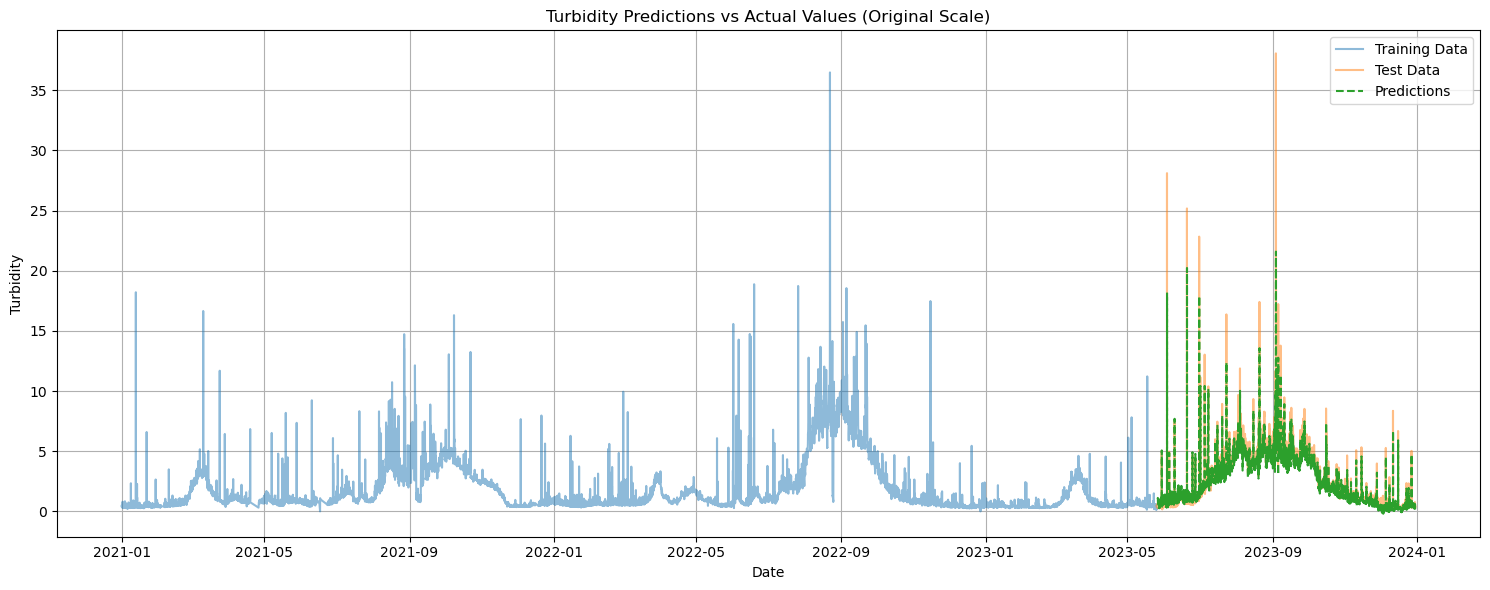

In [15]:
# Convert data back to original scale for visualization
train_original = pd.DataFrame(scaler.inverse_transform(train_data), 
                            columns=Merged_data.columns, 
                            index=train_data.index)

test_original = pd.DataFrame(scaler.inverse_transform(test_data), 
                           columns=Merged_data.columns, 
                           index=test_data.index)

predictions_original = pd.DataFrame(predictions, 
                                  columns=Merged_data.columns, 
                                  index=test_data.index[SEQ_LEN:])

import matplotlib.pyplot as plt

# Create plot
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_original.index, train_original['Turbidity'], 
         label='Training Data', alpha=0.5)

# Plot test data
plt.plot(test_original.index, test_original['Turbidity'], 
         label='Test Data', alpha=0.5)

# Plot predictions
plt.plot(predictions_original.index, predictions_original['Turbidity'],
         label='Predictions', linestyle='--')

plt.title('Turbidity Predictions vs Actual Values (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.grid(True)
plt.tight_layout()

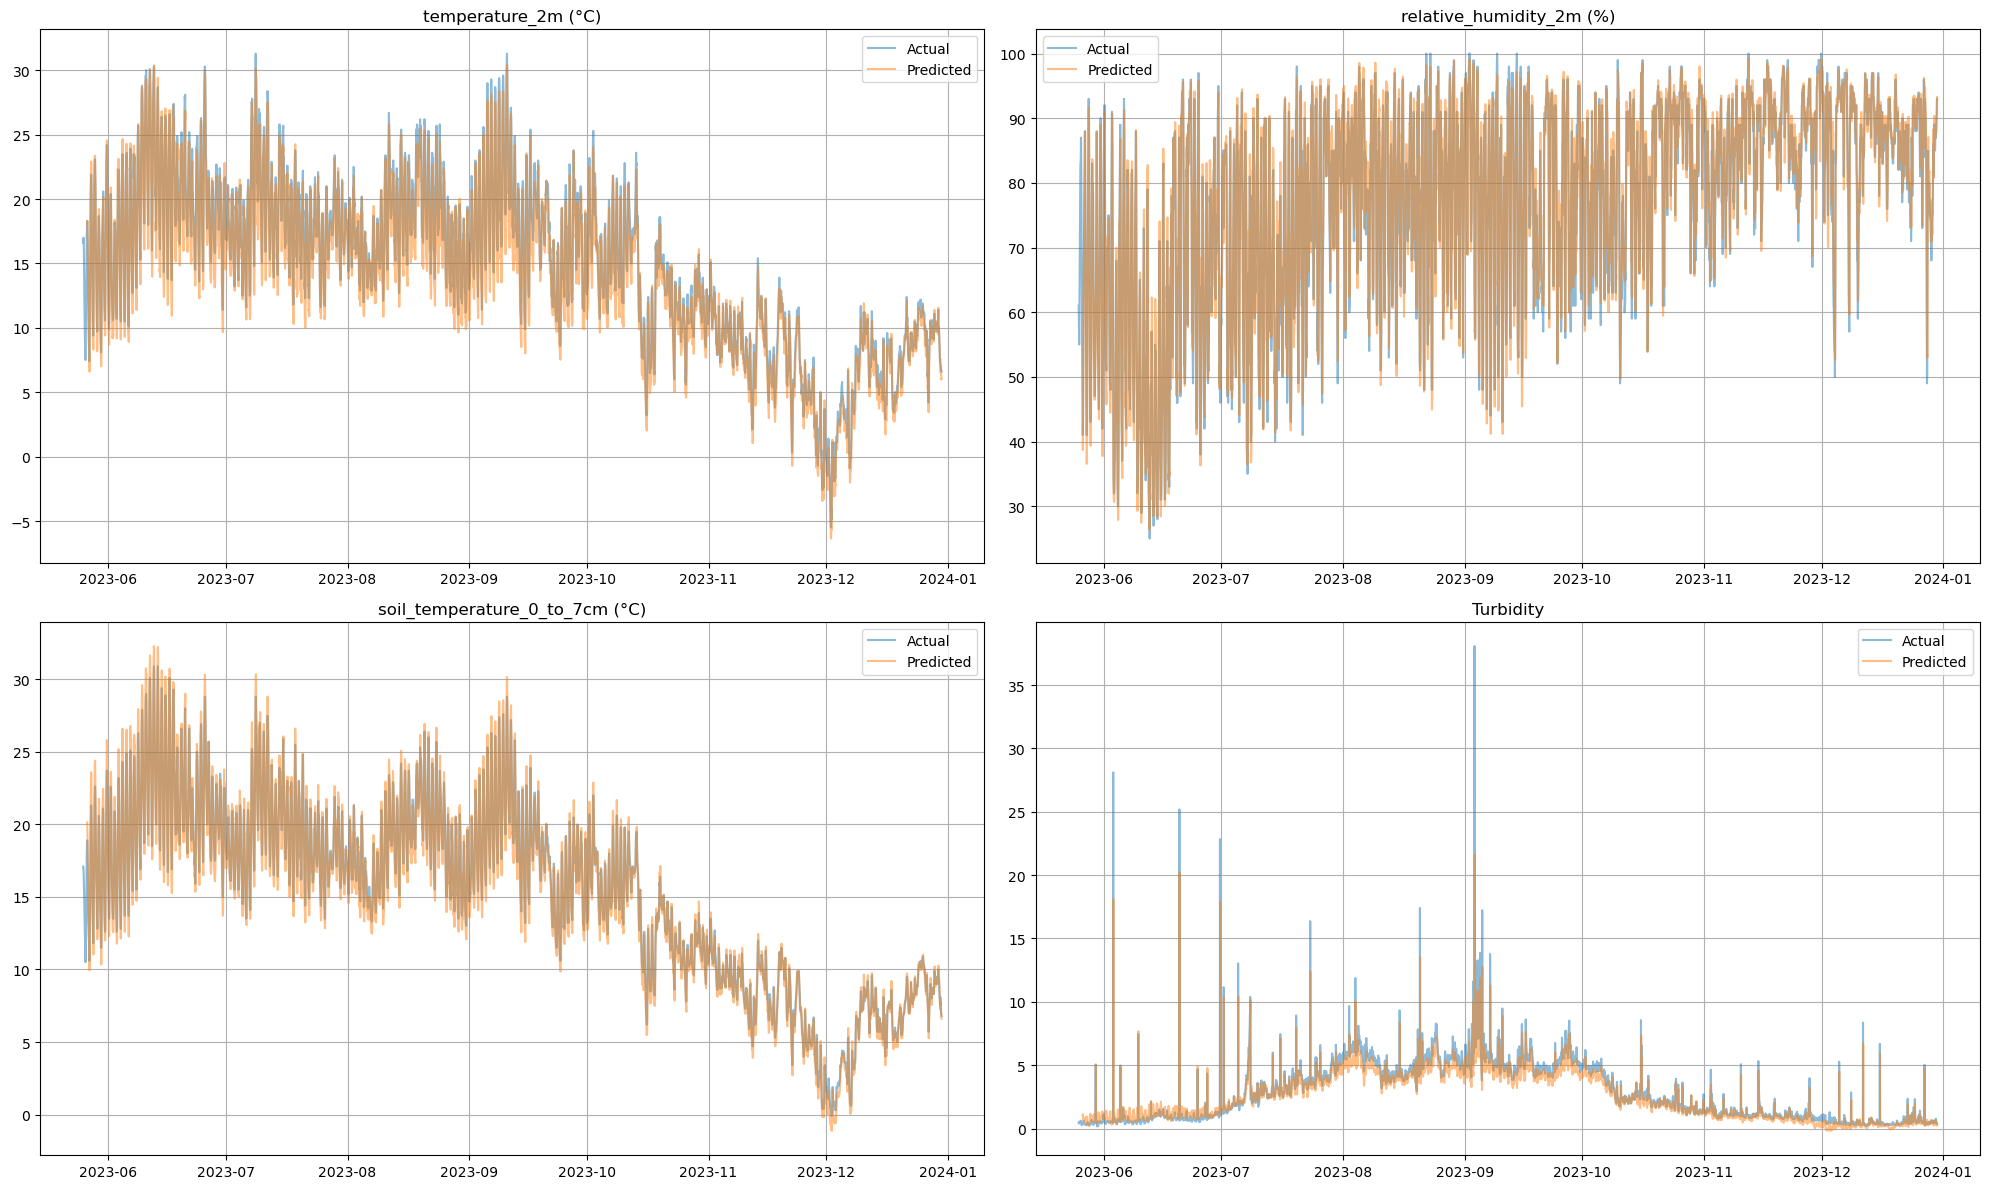

In [17]:
# Convert predictions back to original scale
predictions_df = pd.DataFrame(predictions, index=test_data.index[SEQ_LEN:], columns=Merged_data.columns)
pred_df = pd.DataFrame(predictions, columns=Merged_data.columns, index=test_data.index[SEQ_LEN:])

# Create plot
features_to_plot = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'soil_temperature_0_to_7cm (°C)', 'Turbidity']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()
for idx, feature in enumerate(features_to_plot):
    axes[idx].plot(test_original[feature], label='Actual', alpha=0.5)
    axes[idx].plot(pred_df[feature], label='Predicted', alpha=0.5)
    axes[idx].set_title(feature)
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.tight_layout()
plt.show()

Performance metrics per feature:
                           Feature          MSE        MAE
0              temperature_2m (°C)     1.808251   1.085987
1         relative_humidity_2m (%)    13.978106   2.663415
2               precipitation (mm)     0.274483   0.241770
3  et0_fao_evapotranspiration (mm)     0.001198   0.022421
4            wind_speed_10m (km/h)     4.984464   1.596571
5            wind_gusts_10m (km/h)     8.730257   2.308496
6   soil_temperature_0_to_7cm (°C)     0.443024   0.538167
7   soil_moisture_0_to_7cm (m³/m³)     0.000063   0.005096
8          direct_radiation (W/m²)  3576.628662  33.226162
9                        Turbidity     1.390706   0.510716


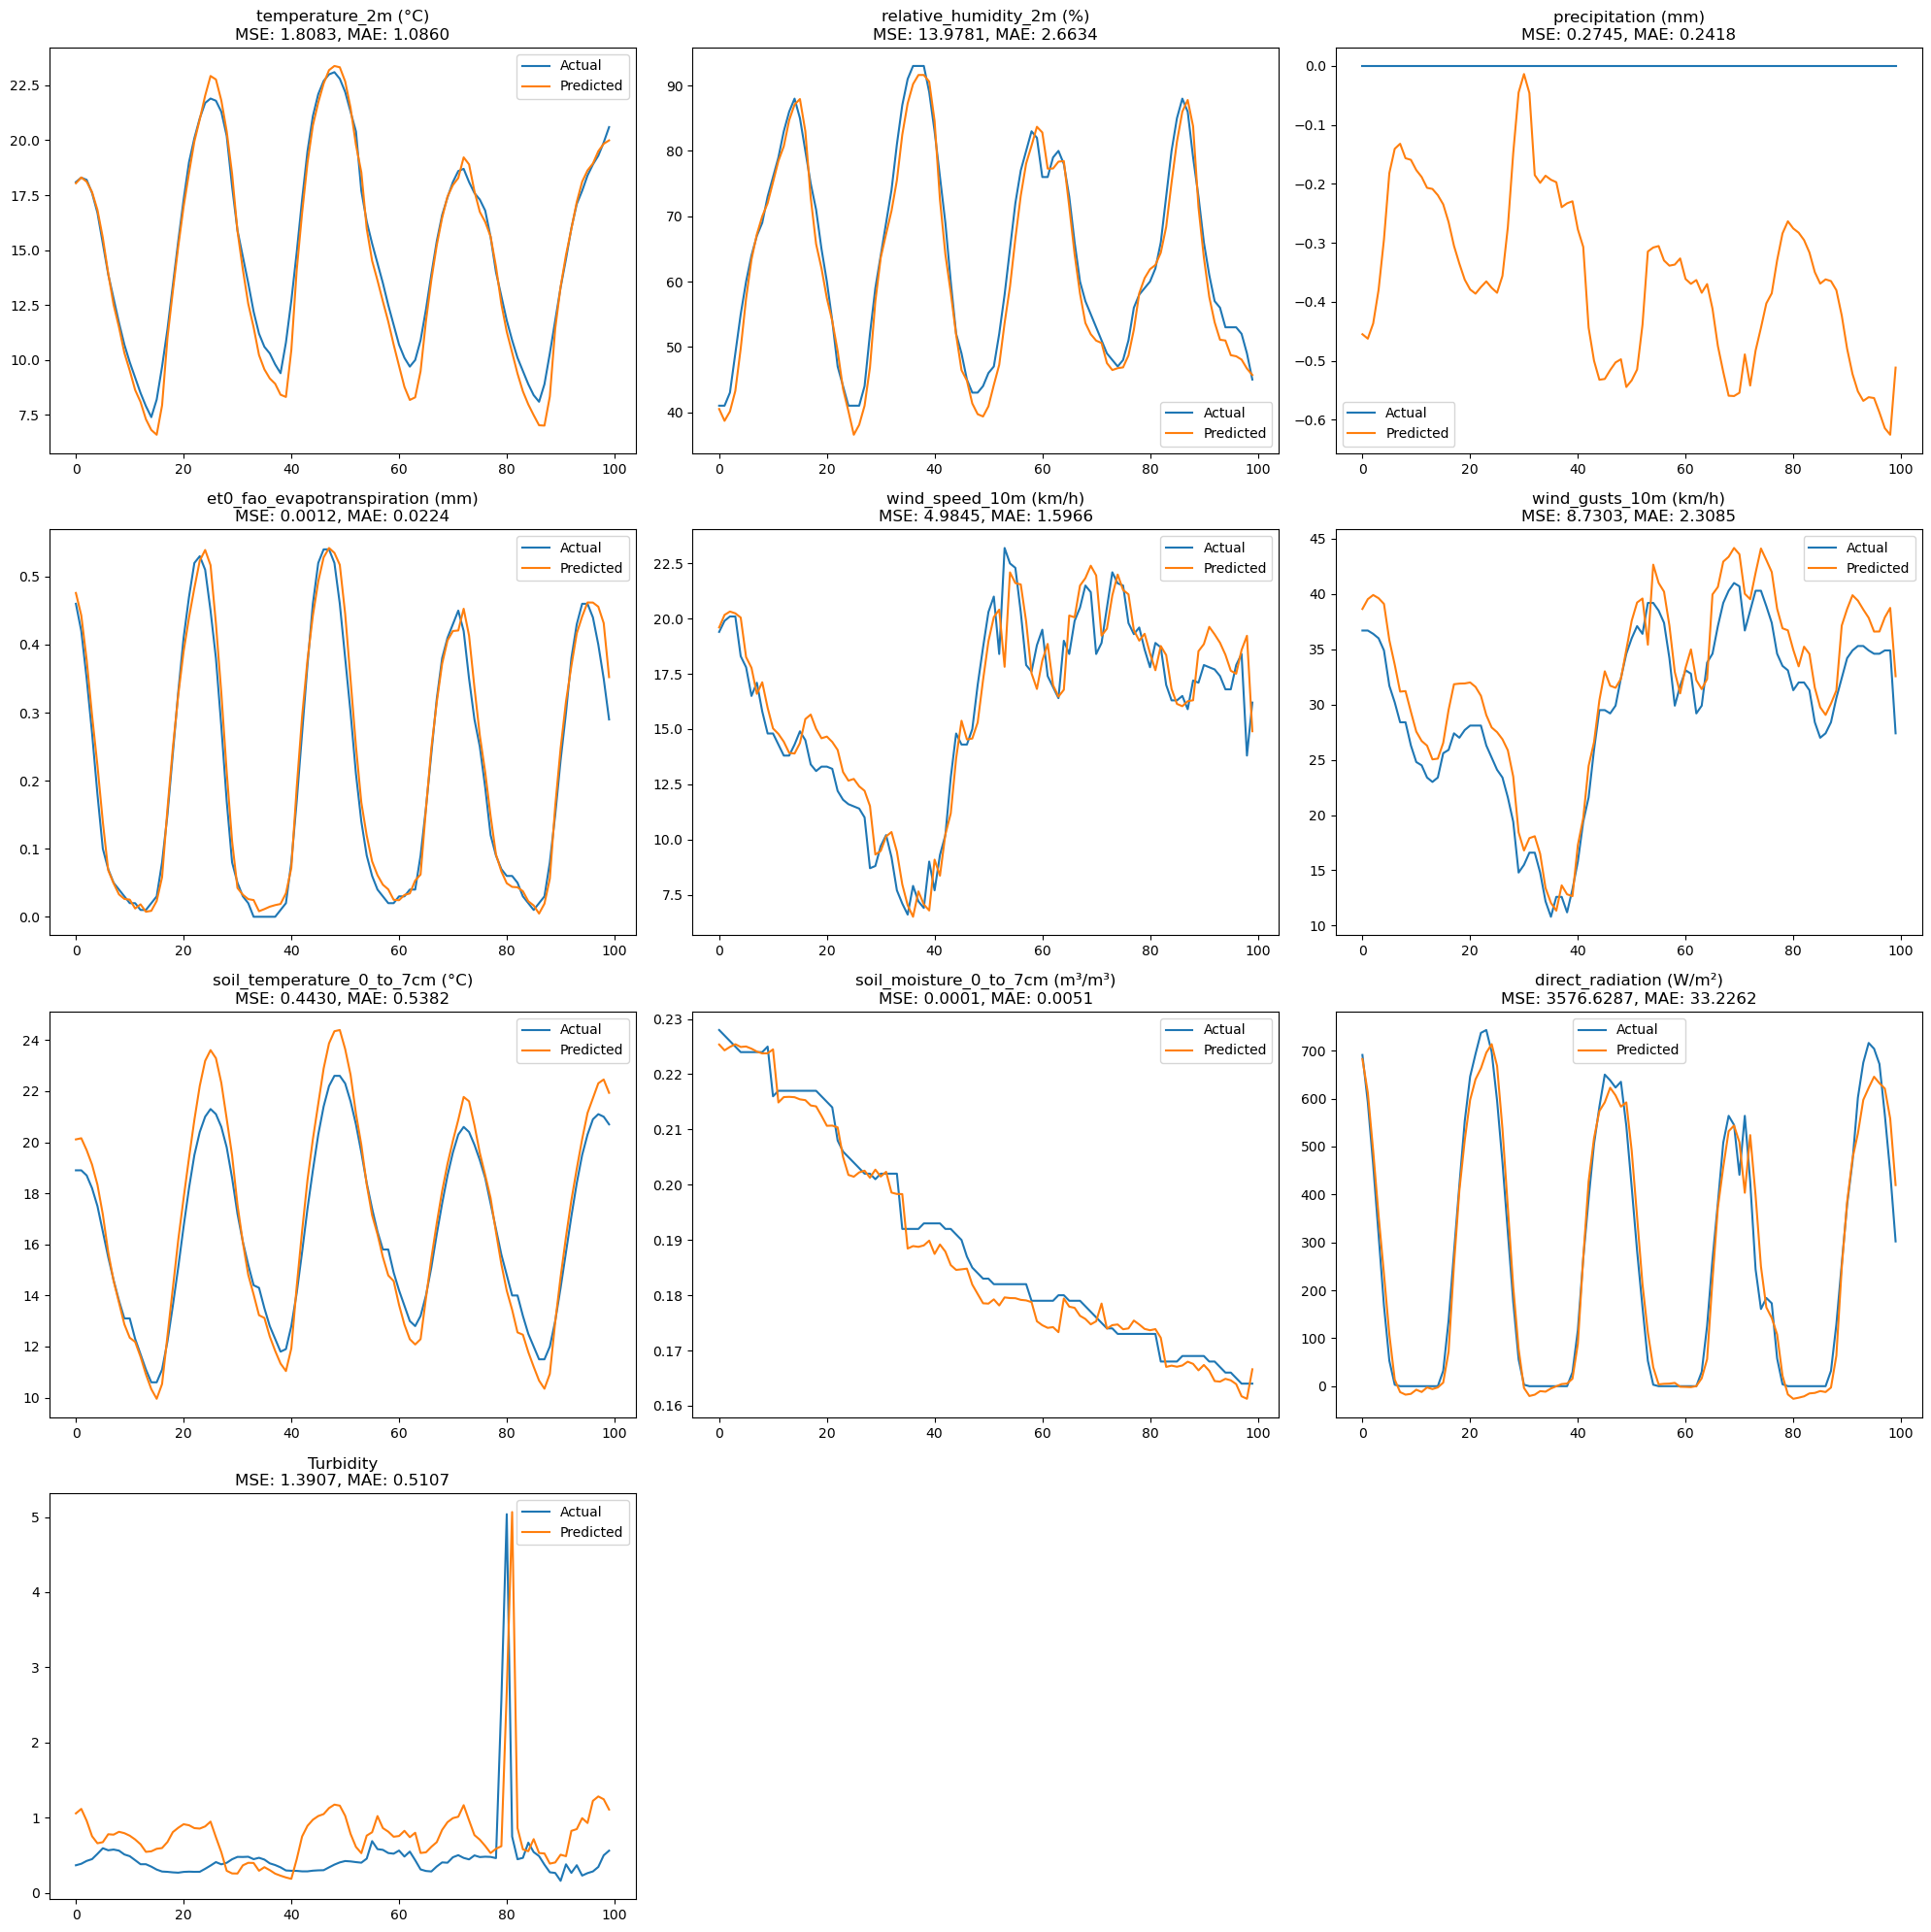


Overall Model Performance:
Mean MSE across all features: 360.8239
Mean MAE across all features: 4.2199

Updated metrics including R-squared:
                           Feature          MSE        MAE  R-squared
7   soil_moisture_0_to_7cm (m³/m³)     0.000063   0.005096   0.992301
6   soil_temperature_0_to_7cm (°C)     0.443024   0.538167   0.988876
0              temperature_2m (°C)     1.808251   1.085987   0.956329
5            wind_gusts_10m (km/h)     8.730257   2.308496   0.952435
1         relative_humidity_2m (%)    13.978106   2.663415   0.942173
3  et0_fao_evapotranspiration (mm)     0.001198   0.022421   0.942049
4            wind_speed_10m (km/h)     4.984464   1.596571   0.914321
8          direct_radiation (W/m²)  3576.628662  33.226162   0.880680
9                        Turbidity     1.390706   0.510716   0.754786
2               precipitation (mm)     0.274483   0.241770   0.068571


In [19]:
# Calculate and visualize metrics for each feature
mse_per_feature = np.mean((predictions - actuals) ** 2, axis=0)
mae_per_feature = np.mean(np.abs(predictions - actuals), axis=0)

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Feature': Merged_data.columns,
    'MSE': mse_per_feature,
    'MAE': mae_per_feature
})

print("Performance metrics per feature:")
print(metrics_df)

# Plot predictions vs actuals for each feature
n_features = Merged_data.shape[1]
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(20, 5*n_rows))
for i, feature in enumerate(Merged_data.columns):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(actuals[:100, i], label='Actual')
    plt.plot(predictions[:100, i], label='Predicted')
    plt.title(f'{feature}\nMSE: {mse_per_feature[i]:.4f}, MAE: {mae_per_feature[i]:.4f}')
    plt.legend()
plt.tight_layout()
plt.show()

# Calculate overall model performance
overall_mse = np.mean(mse_per_feature)
overall_mae = np.mean(mae_per_feature)
print(f"\nOverall Model Performance:")
print(f"Mean MSE across all features: {overall_mse:.4f}")
print(f"Mean MAE across all features: {overall_mae:.4f}")

# Calculate R-squared for each feature
r2_scores = []
for i in range(predictions.shape[1]):
    r2 = 1 - (np.sum((actuals[:, i] - predictions[:, i])**2) / 
              np.sum((actuals[:, i] - np.mean(actuals[:, i]))**2))
    r2_scores.append(r2)

metrics_df['R-squared'] = r2_scores
print("\nUpdated metrics including R-squared:")
print(metrics_df.sort_values('R-squared', ascending=False))


Mean Absolute Percentage Error (MAPE) for Turbidity: 29.87%


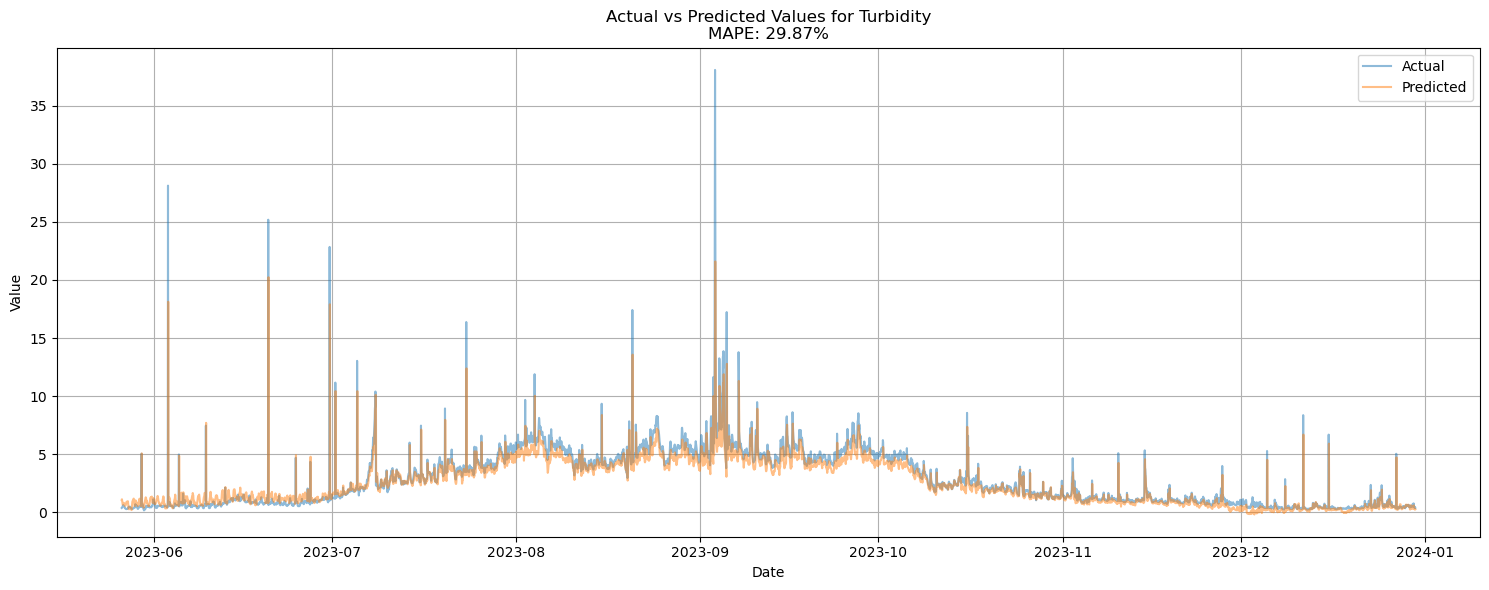

In [20]:

# Calculate MAPE for target variable
target_column = 'Turbidity'
target_actual = pd.DataFrame(actuals[:, -1], columns=[target_column], index=test_data.index[SEQ_LEN:])
target_pred = pd.DataFrame(predictions[:, -1], columns=[target_column], index=test_data.index[SEQ_LEN:])

# Calculate MAPE
mape = np.mean(np.abs((target_actual - target_pred) / target_actual)) * 100

print(f'Mean Absolute Percentage Error (MAPE) for {target_column}: {mape:.2f}%')

# Plot actual vs predicted values with MAPE
plt.figure(figsize=(15, 6))
plt.plot(target_actual.index, target_actual[target_column], label='Actual', alpha=0.5)
plt.plot(target_pred.index, target_pred[target_column], label='Predicted', alpha=0.5)
plt.title(f'Actual vs Predicted Values for {target_column}\nMAPE: {mape:.2f}%')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


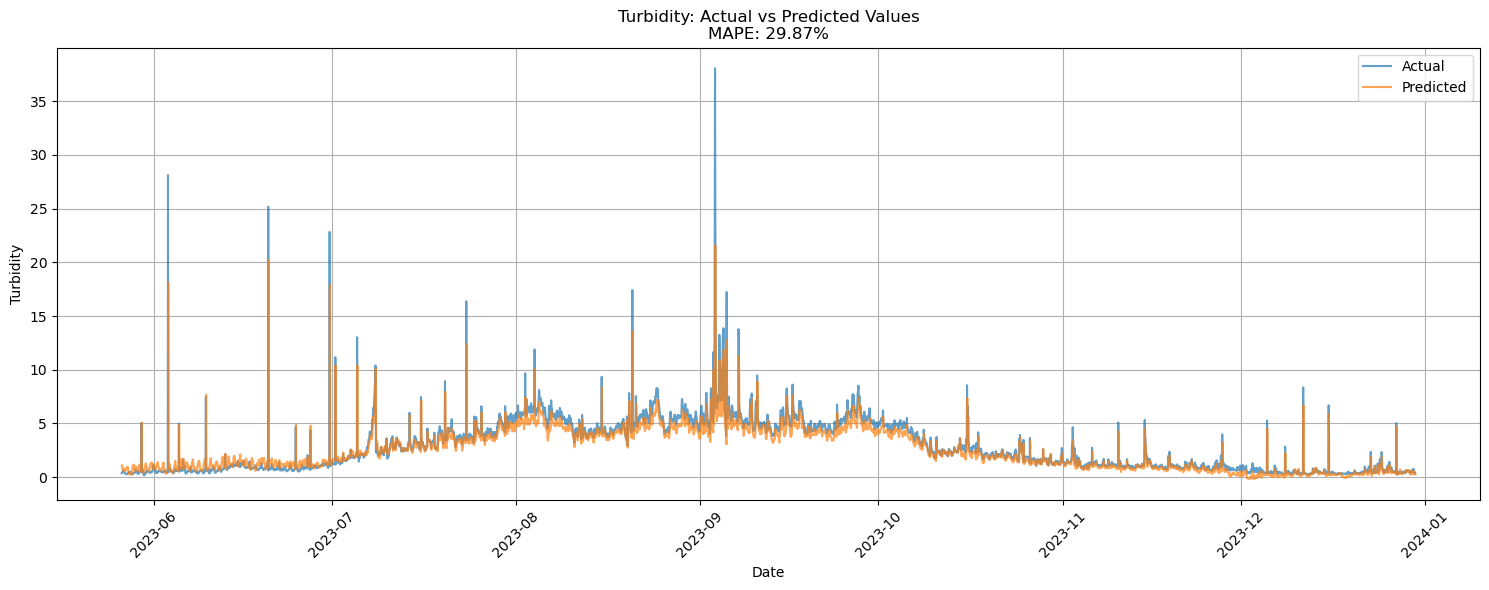

In [21]:
import numpy as np

import matplotlib.pyplot as plt

# Extract only turbidity data from predictions and actuals
turbidity_actual = actuals[:, -1]  # Last column is FLT GEM Turb influent oneven
turbidity_pred = predictions[:, -1]

# Calculate MAPE for turbidity
mape = np.mean(np.abs((turbidity_actual - turbidity_pred) / turbidity_actual)) * 100

# Create time index for plotting
time_index = test_data.index[SEQ_LEN:]  # Adjust index based on sequence length

# Create plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, turbidity_actual, label='Actual', alpha=0.7)
plt.plot(time_index, turbidity_pred, label='Predicted', alpha=0.7)
plt.title(f'Turbidity: Actual vs Predicted Values\nMAPE: {mape:.2f}%')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

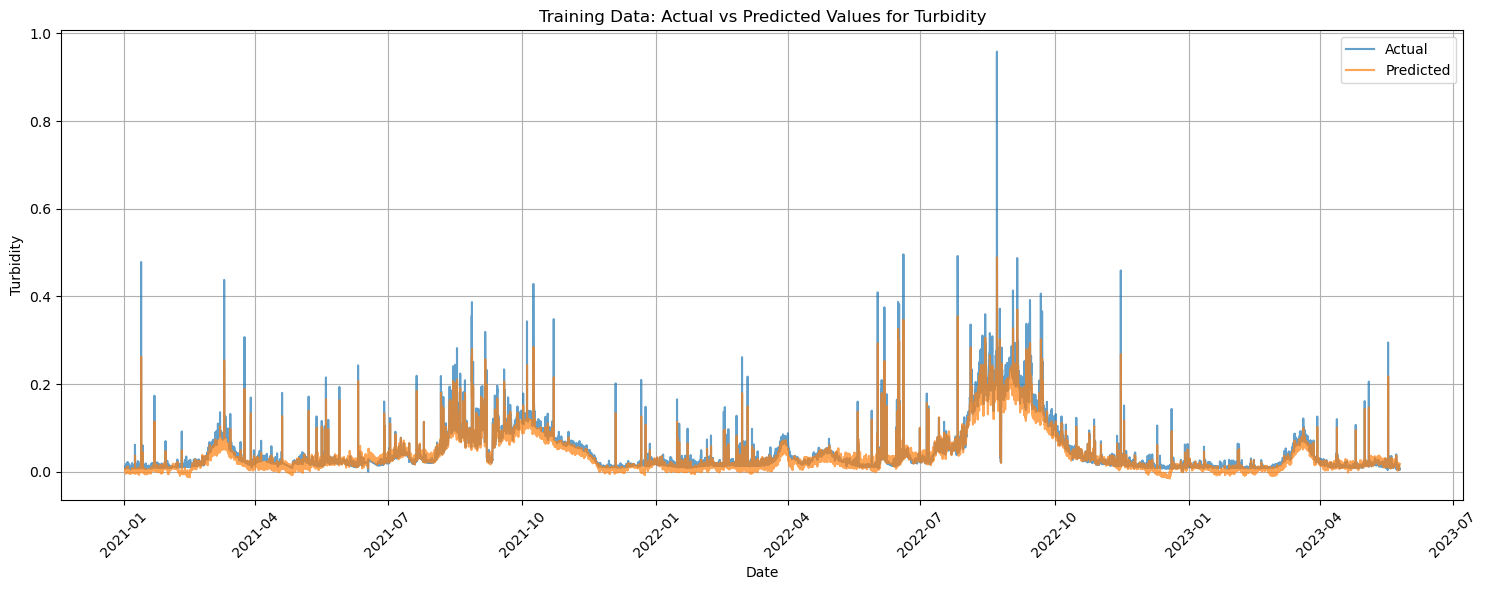

In [23]:
# Plot actual vs predicted values for training data
train_turbidity_actual = train_data.iloc[SEQ_LEN:, -1].values  # Shift actual values to match predicted
train_turbidity_pred = []
for i in range(len(train_data) - SEQ_LEN):
	x = train_data.iloc[i:i+SEQ_LEN].values
	x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
	with torch.no_grad():
		pred = model(x_tensor)
	train_turbidity_pred.append(pred.cpu().numpy()[0, -1])  # Remove batch dimension after prediction
train_turbidity_pred = np.array(train_turbidity_pred)

train_time_index = train_data.index[SEQ_LEN:]  # Adjust index based on sequence length

plt.figure(figsize=(15, 6))
plt.plot(train_time_index, train_turbidity_actual, label='Actual', alpha=0.7)
plt.plot(train_time_index, train_turbidity_pred, label='Predicted', alpha=0.7)
plt.title('Training Data: Actual vs Predicted Values for Turbidity')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Evaluate model performance on test data
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Calculate evaluation metrics
mse = mean_squared_error(turbidity_actual, turbidity_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(turbidity_actual, turbidity_pred)
mape = mean_absolute_percentage_error(turbidity_actual, turbidity_pred) * 100
r2 = r2_score(turbidity_actual, turbidity_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R2): {r2:.4f}")



Mean Squared Error (MSE): 1.3907
Root Mean Squared Error (RMSE): 1.1793
Mean Absolute Error (MAE): 0.5107
Mean Absolute Percentage Error (MAPE): 29.87%
R-squared (R2): 0.7548


In [26]:
# Evaluate model performance on training data
train_mse = mean_squared_error(train_turbidity_actual, train_turbidity_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_turbidity_actual, train_turbidity_pred)
train_mape = mean_absolute_percentage_error(train_turbidity_actual, train_turbidity_pred) * 100
train_r2 = r2_score(train_turbidity_actual, train_turbidity_pred)

# Print evaluation metrics for training data
print(f"Training Data - Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Training Data - Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Training Data - Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"Training Data - Mean Absolute Percentage Error (MAPE): {train_mape:.2f}%")
print(f"Training Data - R-squared (R2): {train_r2:.4f}")

Training Data - Mean Squared Error (MSE): 0.0005
Training Data - Root Mean Squared Error (RMSE): 0.0212
Training Data - Mean Absolute Error (MAE): 0.0114
Training Data - Mean Absolute Percentage Error (MAPE): 421928546379.09%
Training Data - R-squared (R2): 0.8414


c:\Users\Yin Jianing\anaconda3\envs\timeseries\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
100%|██████████| 32/32 [34:56<00:00, 65.50s/it]


Best Parameters: {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 8, 'num_layers': 2}
Best Loss: 0.0015
Training best model with parameters: {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 8, 'num_layers': 2}
Best Model - Mean Squared Error (MSE): 1.2456
Best Model - Root Mean Squared Error (RMSE): 1.1161
Best Model - Mean Absolute Error (MAE): 0.4210
Best Model - Mean Absolute Percentage Error (MAPE): 32.82%


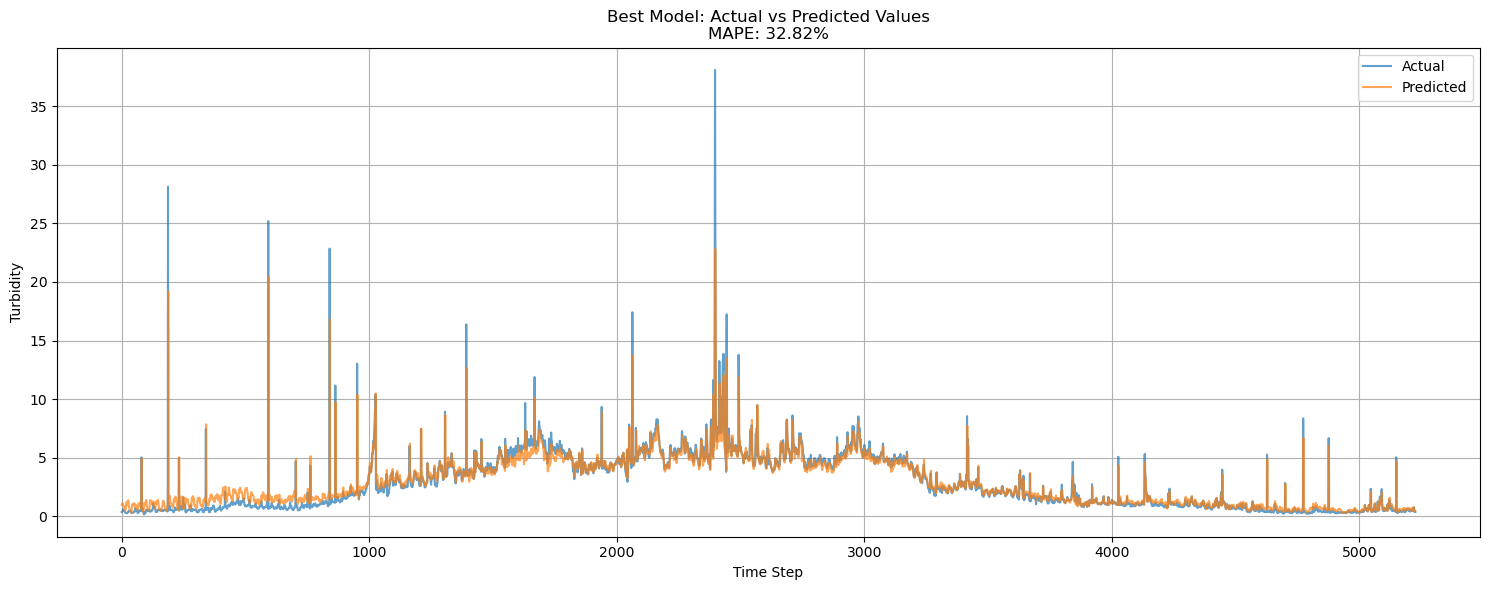

In [28]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

def create_model(d_model, nhead, num_layers, dim_feedforward, dropout):
    return TimeSeriesTransformer(input_dim=Merged_data_scaled.shape[1], d_model=d_model, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout).to(device)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
    
    return total_loss / len(train_loader)
# Define hyperparameter grid
param_grid = {
    'd_model': [32, 64],
    'nhead': [4, 8],
    'num_layers': [2, 3],
    'dim_feedforward': [128, 256],
    'dropout': [0.1, 0.2]
}
# Initialize model
model = create_model(d_model=64, nhead=8, num_layers=3, dim_feedforward=256, dropout=0.1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a function to evaluate the model
def evaluate_model(params):
    model = create_model(**params)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=5)  # Reduced epochs for quick tuning
    return train_loss

# Perform grid search
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
best_params = None
best_loss = float('inf')
for params in tqdm(ParameterGrid(param_grid)):
    loss = evaluate_model(params)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Loss: {best_loss:.4f}")





In [34]:
# Train the best model
best_model = create_model(**best_params)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
print("Training best model with parameters:", best_params)
train_model(best_model, train_loader, criterion, optimizer, num_epochs=10)  # Train for more epochs







c:\Users\Yin Jianing\anaconda3\envs\timeseries\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training best model with parameters: {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 8, 'num_layers': 2}


0.0013919371740485076

In [35]:
# Save the best model
torch.save(best_model.state_dict(), 'best_model.pth')
best_model.eval()

TimeSeriesTransformer(
  (input_layer): Linear(in_features=10, out_features=32, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:
# Evaluate the best model on test data
predictions, actuals = [], []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        preds = best_model(x_batch)
        predictions.append(preds.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

In [37]:
# Convert back to original scale
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)

Best Model on Test Data - Mean Squared Error (MSE): 1.3309
Best Model on Test Data - Root Mean Squared Error (RMSE): 1.1536
Best Model on Test Data - Mean Absolute Error (MAE): 0.4354
Best Model on Test Data - Mean Absolute Percentage Error (MAPE): 21.55%
Best Model on Test Data - R-squared (R2): 0.7653


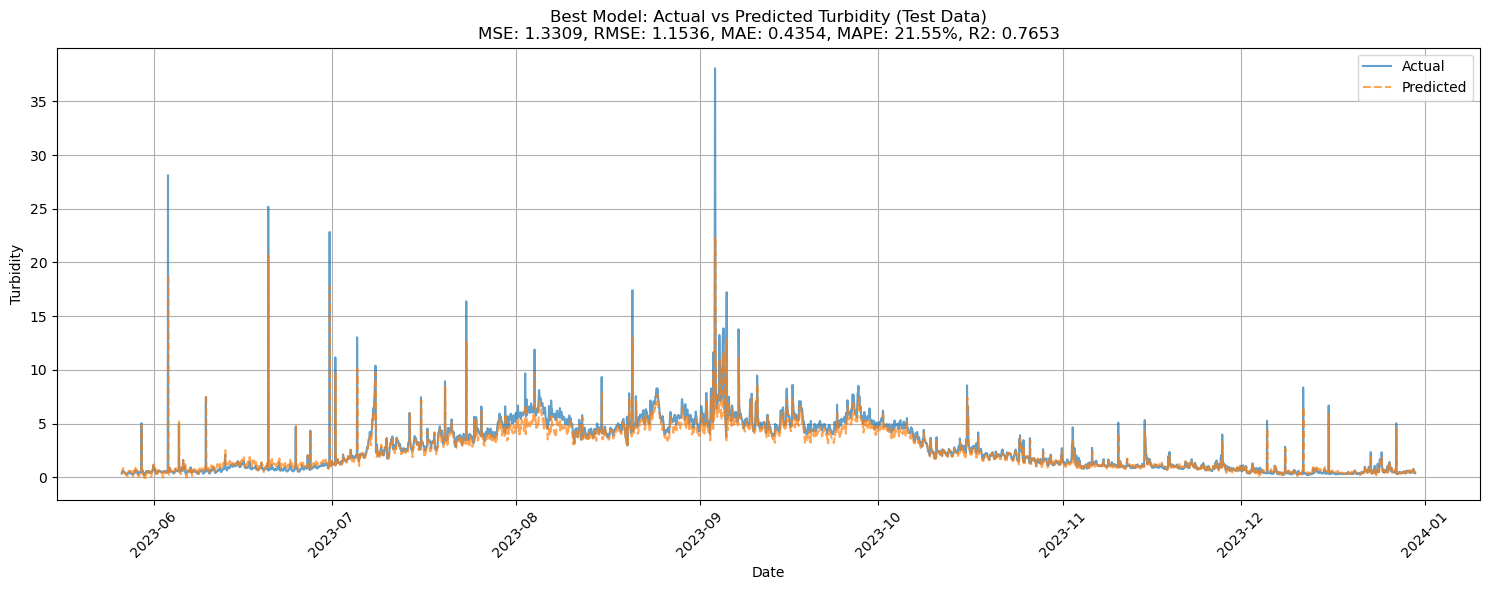

In [43]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# The actuals and predictions are already properly aligned from the test loader
# No need to trim them further

# Calculate evaluation metrics for the target variable (Turbidity, assumed to be the last column)
turbidity_actual = actuals[:, -1]
turbidity_pred = predictions[:, -1]

mse = mean_squared_error(turbidity_actual, turbidity_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(turbidity_actual, turbidity_pred)
# Handle potential division by zero in MAPE if actual values are zero
# Replace zero actual values with a small epsilon or filter them out
# Here, we filter out zero actual values before calculating MAPE
non_zero_actuals_mask = turbidity_actual != 0
if np.any(non_zero_actuals_mask):
	mape = mean_absolute_percentage_error(turbidity_actual[non_zero_actuals_mask], turbidity_pred[non_zero_actuals_mask]) * 100
else:
	mape = np.nan # Or handle as appropriate if all actuals are zero

r2 = r2_score(turbidity_actual, turbidity_pred)

# Print evaluation metrics for the best model on test data
print(f"Best Model on Test Data - Mean Squared Error (MSE): {mse:.4f}")
print(f"Best Model on Test Data - Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Best Model on Test Data - Mean Absolute Error (MAE): {mae:.4f}")
print(f"Best Model on Test Data - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Best Model on Test Data - R-squared (R2): {r2:.4f}")


# Plot actual vs predicted values for the best model (Turbidity)
plt.figure(figsize=(15, 6))
# Ensure the index matches the length of actuals/predictions
time_index = test_data.index[SEQ_LEN:SEQ_LEN+len(turbidity_actual)]
plt.plot(time_index, turbidity_actual, label='Actual', alpha=0.7)
plt.plot(time_index, turbidity_pred, label='Predicted', alpha=0.7, linestyle='--')
plt.title(f'Best Model: Actual vs Predicted Turbidity (Test Data)\n'
		  f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, R2: {r2:.4f}')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


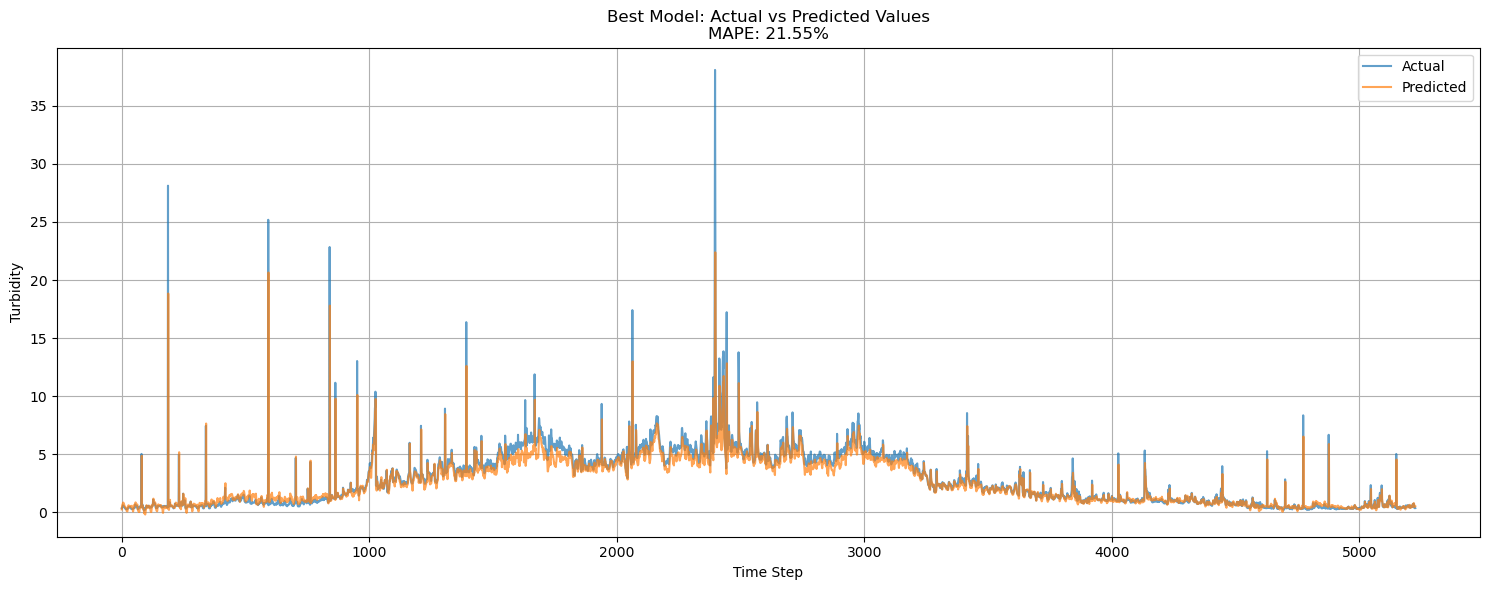

In [44]:
# Plot actual vs predicted values for the best model
plt.figure(figsize=(15, 6))
plt.plot(actuals[:, -1], label='Actual', alpha=0.7)
plt.plot(predictions[:, -1], label='Predicted', alpha=0.7)
plt.title(f'Best Model: Actual vs Predicted Values\nMAPE: {mape:.2f}%')
plt.xlabel('Time Step')
plt.ylabel('Turbidity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

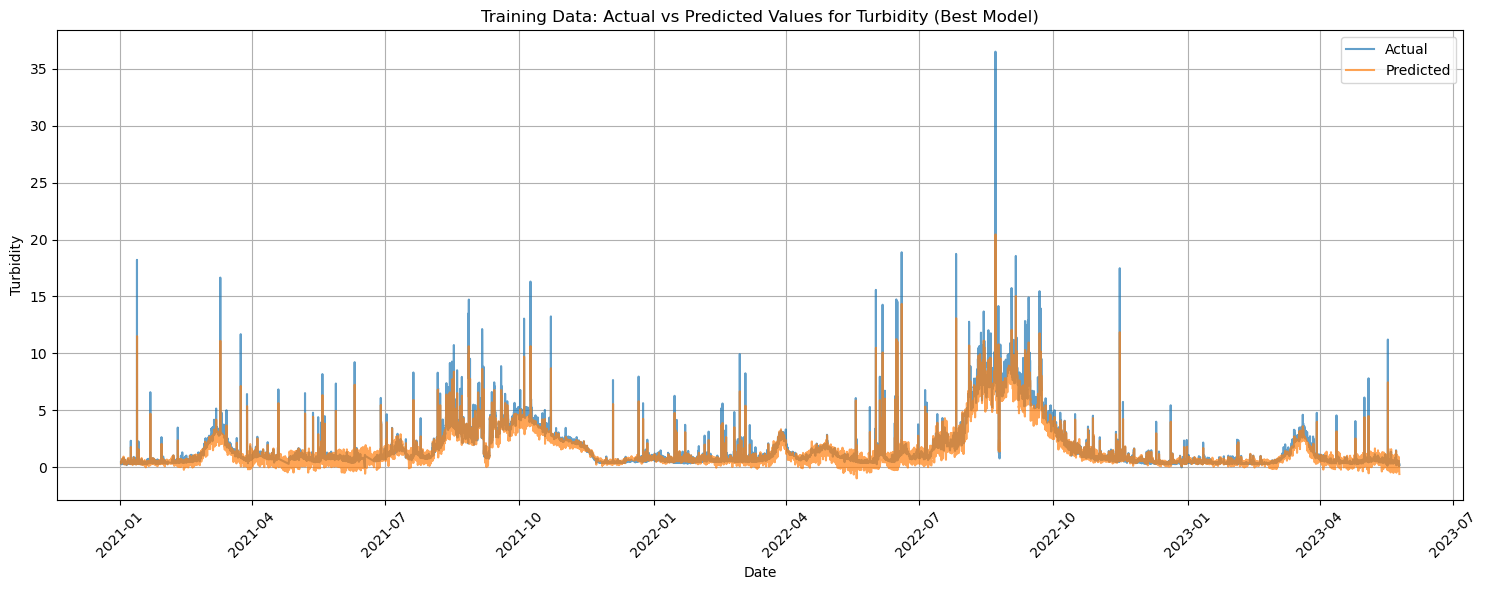

In [45]:
# Use the best model to predict on training data
train_predictions = []
for i in range(len(train_data) - SEQ_LEN):
    x = train_data.iloc[i:i+SEQ_LEN].values
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        pred = best_model(x_tensor)
        train_predictions.append(pred.cpu().numpy()[0, -1])  # Remove batch dimension after prediction
train_predictions = np.array(train_predictions)

# Convert back to original scale for training predictions
# Create a 2D array with zeros for all features
train_predictions_2d = np.zeros((len(train_predictions), Merged_data_scaled.shape[1]))
# Place turbidity predictions in the last column (assuming turbidity is the last column)
train_predictions_2d[:, -1] = train_predictions
# Now we can use inverse_transform
train_predictions_original = scaler.inverse_transform(train_predictions_2d)
# Extract only the turbidity column
train_predictions_original = train_predictions_original[:, -1]

# Do the same for actual values
train_actual_2d = np.zeros((len(train_turbidity_actual), Merged_data_scaled.shape[1]))
train_actual_2d[:, -1] = train_turbidity_actual
train_turbidity_actual_original = scaler.inverse_transform(train_actual_2d)
train_turbidity_actual_original = train_turbidity_actual_original[:, -1]
# Create time index for plotting training predictions
train_time_index = train_data.index[SEQ_LEN:]  # Adjust index based on sequence length
# Create plot for training predictions
plt.figure(figsize=(15, 6))
plt.plot(train_time_index, train_turbidity_actual_original, label='Actual', alpha=0.7)
plt.plot(train_time_index, train_predictions_original, label='Predicted', alpha=0.7)
plt.title('Training Data: Actual vs Predicted Values for Turbidity (Best Model)')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [46]:
# Evaluate the best model on training data
train_mse = mean_squared_error(train_turbidity_actual_original, train_predictions_original)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_turbidity_actual_original, train_predictions_original)
train_mape = mean_absolute_percentage_error(train_turbidity_actual_original, train_predictions_original) * 100
train_r2 = r2_score(train_turbidity_actual_original, train_predictions_original)
# Print evaluation metrics for the best model on training data
print(f"Best Model on Training Data - Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Best Model on Training Data - Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Best Model on Training Data - Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"Best Model on Training Data - Mean Absolute Percentage Error (MAPE): {train_mape:.2f}%")
print(f"Best Model on Training Data - R-squared (R2): {train_r2:.4f}")

Best Model on Training Data - Mean Squared Error (MSE): 0.6497
Best Model on Training Data - Root Mean Squared Error (RMSE): 0.8060
Best Model on Training Data - Mean Absolute Error (MAE): 0.3972
Best Model on Training Data - Mean Absolute Percentage Error (MAPE): 10537605809293.98%
Best Model on Training Data - R-squared (R2): 0.8422
